# Prediciendo la volatilidad de criptomonedas con modelos ARIMA-GARCH

## Introducción

Este proyecto es un resumen de lo realizado en mi proyecto de fin de grado para la obtención del grado en Economía.

Se modeliza la volatilidad de tres activos (bitcoin, tether y SP500) a través de modelos ARIMA-ARCH con el objetivo de observar las diferencias de las dinámicas de las criptomonedas respecto a la bolsa americana. 

Para la realización del trabajo, usamos diferentes librerías estadísticas-econométricas (statsmodels, arch) junto a librerías de visualización (matplotlib, seaborn).

En último lugar, se presentan las predicciones de la volatidad para cada uno de los activos

In [50]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import statsmodels.graphics.tsaplots as sgt 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
sns.set_style("dark")
from arch import arch_model

import warnings
warnings.filterwarnings("ignore")

## 1. Extracción de datos financieros

In [2]:
def get_log_returns(ticker):
    """ Generamos la serie temporal de retornos logarítmicos
    Args:
        ticker (str): símbolo del activo en el que calcular la serie
    Returns:
        Series
    """
    adj_close = yf.download(ticker, start = '2016-01-01', end = '2022-06-05')['Adj Close']
    log_returns = 100 * np.log(1 + adj_close.pct_change()).dropna()
    log_returns = log_returns.to_frame()
    return log_returns

btc = get_log_returns('BTC-USD')
tether = get_log_returns('USDT-USD')
sp500 = get_log_returns('^GSPC')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
btc = btc.rename(columns = {'Adj Close':'log_returns'})
btc

,log_returns
Date,
2016-01-01,0.871095
2016-01-02,-0.206512
2016-01-03,-0.793798
2016-01-04,0.713712
2016-01-05,-0.261490
...,...
2022-05-31,0.207561
2022-06-01,-6.474693
2022-06-02,2.218263


In [4]:
tether = tether.rename(columns = {'Adj Close':'log_returns'}) 
tether

,log_returns
Date,
2017-11-10,-0.215468
2017-11-11,0.295781
2017-11-12,0.344302
2017-11-13,-0.308639
2017-11-14,-0.249974
...,...
2022-05-31,0.001199
2022-06-01,-0.012806
2022-06-02,0.005702


In [5]:
sp500 = sp500.rename(columns = {'Adj Close':'log_returns'})
sp500

,log_returns
Date,
2016-01-04,-1.542204
2016-01-05,0.201020
2016-01-06,-1.320216
2016-01-07,-2.398582
2016-01-08,-1.089754
...,...
2022-05-27,2.444113
2022-05-31,-0.629414
2022-06-01,-0.751091


In [6]:
def tabla_estadistica(series):
    """ Genera tabla estadística descriptiva
    Args:
        series(series) = serie en la que realizamos la tabla
    Returns:
        Dataframe
    """
    describe = pd.DataFrame(series.describe())
    # Skewness
    describe.loc[8] = series.skew()
    # Kurtosis
    describe.loc[9] = series.kurt()
    # Range
    describe.loc[10] = series.max() - series.min()
    # IQR
    describe.loc[11] = series.quantile(.75) - series.quantile(.25)
    # CV 
    describe.loc[12] = series.std()/series.mean()
    describe.rename(index = {8:'Skewness',9:'Kurtosis',10:'Range',11:'IQR',12:'CV'}, inplace = True)
    print(describe)

In [7]:
tabla_estadistica(btc)

          log_returns
count     2347.000000
mean         0.180582
std          3.963548
min        -46.473018
25%         -1.381118
50%          0.209642
75%          1.828448
max         22.511895
Skewness    -0.726181
Kurtosis    11.260086
Range       68.984913
IQR          3.209566
CV          21.948720


In [8]:
tabla_estadistica(tether)

          log_returns
count     1668.000000
mean        -0.000530
std          0.475292
min         -5.256973
25%         -0.103055
50%         -0.001644
75%          0.099463
max          5.660626
Skewness     0.673250
Kurtosis    40.455851
Range       10.917599
IQR          0.202519
CV        -897.428069


In [9]:
tabla_estadistica(sp500)

          log_returns
count     1617.000000
mean         0.043178
std          1.189648
min        -12.765220
25%         -0.323550
50%          0.074553
75%          0.558473
max          8.968323
Skewness    -1.028094
Kurtosis    19.036686
Range       21.733543
IQR          0.882023
CV          27.552165


Los retornos logarítmicos muestran un gran nivel de curtosis.
Bitcoin tiene una rentabilidad media mayor, pero se mueve en un mayor rango y llega a
tener la rentabilidad mínima más baja de los tres activos.

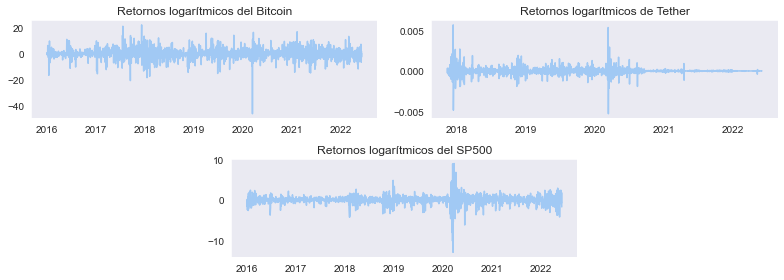

In [10]:
## Graficación de los retornos logarítmicos de los activosb
plt.figure(figsize = (11,4))
sns.set_palette(sns.color_palette("pastel"))
gs = gridspec.GridSpec(4, 4)
ax1 = plt.subplot(gs[:2, :2])
plt.title('Retornos logarítmicos del Bitcoin')
plt.plot(btc)
ax2 = plt.subplot(gs[:2, 2:])
plt.title('Retornos logarítmicos de Tether')
plt.plot(tether/1000)
ax3 = plt.subplot(gs[2:4, 1:3])
plt.title('Retornos logarítmicos del SP500')
plt.plot(sp500)
plt.tight_layout()
plt.show()

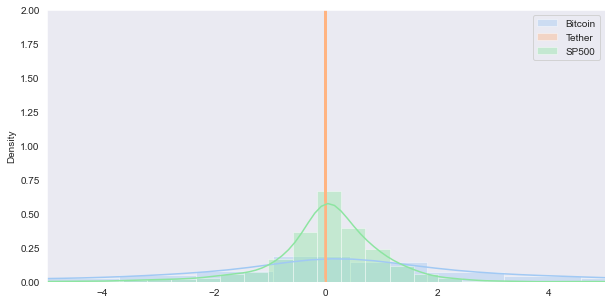

In [11]:
plt.figure(figsize = (10,5))
plt.xlim(-5,5)
plt.ylim(0,2)
sns.set_palette(sns.color_palette("pastel"))
sns.distplot(btc, label = 'Bitcoin')
sns.distplot(tether/1000, label = 'Tether')
sns.distplot(sp500, label = 'SP500')
plt.legend()
plt.show()


Como era previsible, los valores
de Tether se centran en el valor cero debido a su escasa variación por su paridad con el
dólar americano. En cambio, la distribución de bitcoin y SP500 parecen seguir una
distribución T de Student presentando colas más pesadas que la curva de Gauss,
asemejándose más al comportamiento de un activo del mercado financiero.

## 2. Estimación de modelos ARIMA-GARCH

En este segundo apartado, se realizará todo el procedimiento hasta la validación de los modelos ARIMA-GARCH seleccionados para posteriormente realizar una predicción de la volatilidad de los tres intrumentos de inversión. 

Los pasos que se realizarán en esta sección serán:
    
- **2.1. Modelización ARIMA y tratamiento de los atípicos**: Estimación de un modelo ARIMA para cada serie de retornos logarítmicos, con el fin de incorporar en el modelo componentes de medias móviles, autorregresivos y valores atípicos.
- **2.2. Estudio de los residuos normales y al cuadrado del modelo ARIMA estimado**: Se comprobarán hipótesis de incorrelación de errores y normalidad en los residuos normales y la existencia de correlación entre los errores al cuadrado.
- **2.3. Modelización GARCH**: Estimación de un modelo GARCH básico de orden (1,1). 
    - **2.3.1. Amplicaciones de modelos GARCH**: Estimaciones de modelos GARCH ampliados que permitan mejorar nuestra capacidad explicativa
- **2.4. Estudio de los residuos GARCH estimados**: Demostración de la no existencia de heterocedasticidad y autocorrelación entre los errores al cuadrado como validación del modelo GARCH escogido.

### 2.1. Modelización ARIMA y tratamiento de los datos atípicos (1/4)

Una vez obtenidos las rentabilidades logarítmicas de los tres instrumentos financieros, procedemos al tratamiento de los datos atípicos.

La primera función muestra los valores atípicos de la serie según un criterio de desviación típica para facilitarnos la toma de decisión de qué outliers añadir en los modelos ARIMA.

La Segunda función prepara el DataFrame sobre el que posteriormente se modelizarán los ARIMAX. Acepta una serie y el número de desviaciones típicas que queramos usar como criterio para definir los valores atípicos. Por cada valor atípico encontrado, la función creará una columna en el DataFrame con nombre de ese outlier que tomará valor 1 si la observación tiene ese valor y 0 si no lo hace, creando por lo tanto una variable dummy por cada outlier encontrado. La función devolverá el DataFrame final.

In [41]:
def showing_outliers(serie, std_criteria):
    """ Presenta los valores atípicos de una serie dada según un criterio de desviación típica
    Args:
        serie (series): serie temporal en la que nos basamos para detectar los outliers
        std_criteria (int): número de veces en la que se debe de salir de las desviación típico un valor
        para ser considerado un valor atípico      
    """
    series = serie.copy()
    desviation = float(series.std()*std_criteria)
    outliers = []
    for index, row in series.iterrows():
        if (float(row) > desviation) or (float(row) < -desviation):
            outliers.append(float(row))
    print('Valores atípicos: ',outliers)
    print('Número de valores atípicos: ', len(outliers))
    
def preparing_temporal_series(serie, std_criteria):
    """Crea una dataframe con columnas binarias de los valores atípicos
    Args:
        serie (series): serie temporal en la que nos basamos para detectar los outliers
        std_criteria (int): número de veces en la que se debe de salir de las desviación típico un valor
        para ser considerado un valor atípico
    
    Returns:
        Dataframe
    """
    series = serie.copy()    
    desviation = float(series.std()*std_criteria)
    # obteniendo lista de outliers
    outliers = []
    for index, row in series.iterrows():
        if (float(row) > desviation) or (float(row) < -desviation):
            outliers.append(float(row))
    # creamos una variable dummy por cada valor atípico
    for n, outlier in zip(range(1,len(outliers)+1), outliers):
        col_name = 'out ' + str(n)
        series[col_name] = series['log_returns'].apply(lambda x: 1 if x == outlier else 0)
    return series

Los resultados de los valores atípicos demuestran que el mejor criterio es añadir los valores a partir de las 5 desviaciones típicas para evitar problemas de infra/sobreajuste en los modelos.

In [45]:
for std_candidate in [3,5,7]:
    print('Valores atípicos de {} con {} desviaciones típicas'.center(123, '-').format('bitcoin', std_candidate))
    showing_outliers(btc, std_candidate)

-------------------------------------Valores atípicos de bitcoin con 3 desviaciones típicas------------------------------------
Valores atípicos:  [-16.64338052665779, -13.05752503587256, -15.4476649076822, -12.205008924073008, 14.38615807515655, 21.459581921064387, -20.75298468188717, 14.23295036032813, 12.6296016703469, 12.093108463263826, 18.172416088180857, 22.511895434132782, -13.32232172821606, 13.78513383721832, -12.359779448691187, -18.458172530715174, -17.39821153312485, 12.412693581038274, -14.356147255391308, 16.00419797683949, 12.175582015101313, 11.992989942799603, -15.181967393698741, -13.937670558066412, -12.09936495214672, 14.476109386093217, -46.4730175339773, 16.71043242496126, 11.984140644428901, -14.252813081835994, 17.18205618881233, -14.2967146773037, -14.810707635188663, -11.9521795848678, 13.576425730332167]
Número de valores atípicos:  35
-------------------------------------Valores atípicos de bitcoin con 5 desviaciones típicas---------------------------------

In [46]:
for std_candidate in [3,5,7]:
    print('Valores atípicos de {} con {} desviaciones típicas'.center(123, '-').format('tether', std_candidate))
    showing_outliers(tether, std_candidate)

-------------------------------------Valores atípicos de tether con 3 desviaciones típicas------------------------------------
Valores atípicos:  [1.7505795477082406, 2.130791181877143, 5.660625606298034, -4.819841255840815, -1.8641080108855683, 2.647475492845963, -2.149675915702048, 1.5501122709679496, 2.6981604325763797, -1.915444216551417, -1.8317347406879698, 1.7334463093974892, -1.6625696420604554, 1.8871824697148807, -1.8931134958676081, 1.5783431105178645, -1.427722905445387, 1.9123398009735944, -1.577007372245821, 1.4486216089913446, 1.83480997823081, 1.502744811250073, 5.3393397894479016, -5.256973240306426, -2.114358370727026, 2.9277329753384524, 1.4748188050432245, 1.6916444927254644, -1.4881305479267513, -1.6074832754024264, -1.8985031745432983]
Número de valores atípicos:  31
-------------------------------------Valores atípicos de tether con 5 desviaciones típicas------------------------------------
Valores atípicos:  [5.660625606298034, -4.819841255840815, 2.647475492845

In [47]:
for std_candidate in [3,5,7]:
    print('Valores atípicos de {} con {} desviaciones típicas'.center(123, '-').format('sp500', std_candidate))
    showing_outliers(sp500, std_candidate)

-------------------------------------Valores atípicos de sp500 con 3 desviaciones típicas------------------------------------
Valores atípicos:  [-3.6580792805582627, -4.184254093838143, -3.82590522458017, 4.840317767080503, -4.516813635226115, 4.50108687694132, 4.133634936063314, -7.901041294037148, 4.821505242585911, -5.01028928086054, -9.994485240247352, 8.880840694923595, -12.765219747281742, 5.822631263569171, -5.322227233208024, -4.432762405336681, 8.968323251796326, 6.054383107424656, -4.514636273278691, 6.796824414483035, -6.075269299628893, -3.5757594142185303, -3.592554210857772, -3.6959159784694147, -3.630067756409906, -4.123380929124887]
Número de valores atípicos:  26
-------------------------------------Valores atípicos de sp500 con 5 desviaciones típicas------------------------------------
Valores atípicos:  [-7.901041294037148, -9.994485240247352, 8.880840694923595, -12.765219747281742, 8.968323251796326, 6.054383107424656, 6.796824414483035, -6.075269299628893]
Número 

Se presentan los modelos ARIMAX de los tres activos, con resultados favorables por la significancia individual de cada unos de los valores atípicos y componentes autorregresivos y de medias móviles añadidos.

*Se añadieron el número máximo de componentes AR y MM posibles manteniendo la significancia individual de todos las variables explicativas*

In [16]:
btc_df = preparing_temporal_series(btc, 5)
arma_model = sm.tsa.SARIMAX(endog= btc_df.iloc[:,0], exog = btc_df.iloc[:,1:], order=(1, 1, 0))
_model_result = arma_model.fit()
print(_model_result.summary())
btc_resid = _model_result.resid

                               SARIMAX Results                                
Dep. Variable:            log_returns   No. Observations:                 2347
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -6906.888
Date:                Fri, 16 Sep 2022   AIC                          13825.776
Time:                        22:09:37   BIC                          13860.339
Sample:                    01-01-2016   HQIC                         13838.365
                         - 06-04-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
out 1         19.4436      4.724      4.116      0.000      10.185      28.702
out 2        -21.6247      2.121    -10.196      0.000     -25.781     -17.468
out 3         23.1615      1.597     14.501      0.0

In [17]:
tether_df = preparing_temporal_series(tether, 5)
arma_model = sm.tsa.SARIMAX(endog= tether_df.iloc[:,0], exog = tether_df.iloc[:,1:], order=(1, 0, 1))
_model_result = arma_model.fit()
print(_model_result.summary())
tether_resid = _model_result.resid

                               SARIMAX Results                                
Dep. Variable:            log_returns   No. Observations:                 1668
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -593.353
Date:                Fri, 16 Sep 2022   AIC                           1206.706
Time:                        22:09:39   BIC                           1260.900
Sample:                    11-10-2017   HQIC                          1226.788
                         - 06-04-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
out 1          5.5929      0.485     11.530      0.000       4.642       6.544
out 2         -5.5958      0.295    -18.949      0.000      -6.175      -5.017
out 3          1.3512      0.062     21.849      0.0

In [18]:
sp500_df = preparing_temporal_series(sp500, 5)
arma_model = sm.tsa.SARIMAX(endog= sp500_df.iloc[:,0], exog = sp500_df.iloc[:,1:], order=(0, 0, 0))
_model_result = arma_model.fit()
print(_model_result.summary())
sp500_resid = _model_result.resid

                               SARIMAX Results                                
Dep. Variable:            log_returns   No. Observations:                 1617
Model:                        SARIMAX   Log Likelihood               -2328.087
Date:                Fri, 16 Sep 2022   AIC                           4674.175
Time:                        22:09:39   BIC                           4722.670
Sample:                             0   HQIC                          4692.173
                               - 1617                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
out 1         -7.9010   2.76e-14  -2.86e+14      0.000      -7.901      -7.901
out 2         -9.9945   2.76e-14  -3.62e+14      0.000      -9.994      -9.994
out 3          8.8808   2.76e-14   3.22e+14      0.0

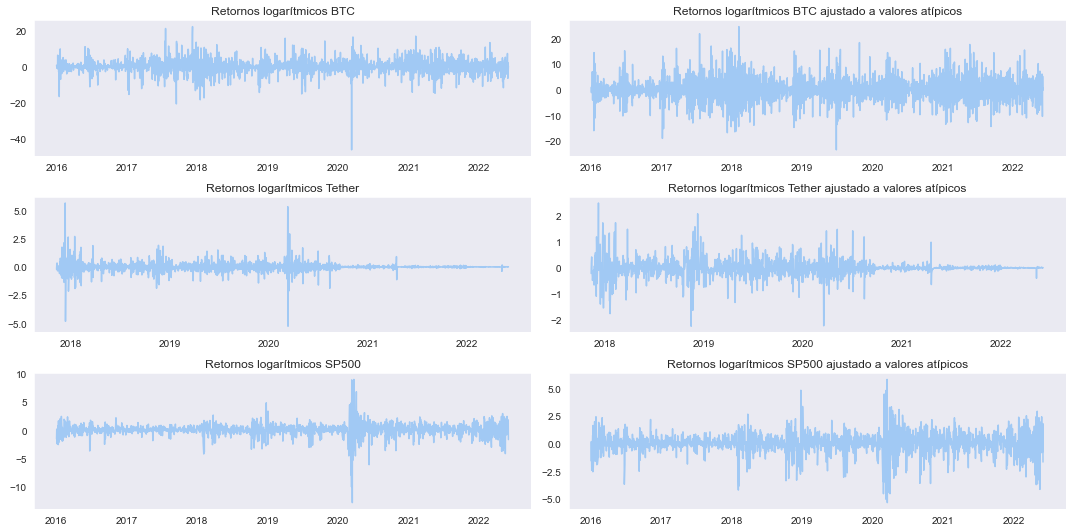

In [19]:
plt.figure(figsize = (15,7.5))
plt.subplot(321)
plt.title('Retornos logarítmicos BTC')
plt.plot(btc)
plt.subplot(322)
plt.title('Retornos logarítmicos BTC ajustado a valores atípicos')
plt.plot(btc_resid)
plt.subplot(323)
plt.title('Retornos logarítmicos Tether')
plt.plot(tether)
plt.subplot(324)
plt.title('Retornos logarítmicos Tether ajustado a valores atípicos')
plt.plot(tether_resid)
plt.subplot(325)
plt.title('Retornos logarítmicos SP500')
plt.plot(sp500)
plt.subplot(326)
plt.title('Retornos logarítmicos SP500 ajustado a valores atípicos')
plt.plot(sp500_resid)
plt.tight_layout()
plt.show()

### 2.2. Estudio de los residuos normales y al cuadrado del modelo ARIMA estimado (2/4)

#### Análisis de los residuos normales del modelo ARIMA

Para la evaluación de los residuos normales del modelo ARIMA pediremos el cumplimiento de tres hipótesis:
- Incorrelación de los errores a través de la función de autocorrelación.
- Incorrelación de los errores a través de la función de autocorrelación parcial.
- Normalidad en los residuos a través del gráfico Q-Q.

In [20]:
def correlograma(series, title = '', lags = 20):
    fig, axs = plt.subplots(2,2, figsize=(10, 6))
    fig.suptitle(title, fontsize=16, x = 0.53)
    axs[0,0].plot(series)
    axs[0,0].set_xticklabels([])
    stats.probplot(series.array, plot=axs[0,1])
    sgt.plot_pacf(series, lags = lags, zero = False, ax = axs[1,0])
    sgt.plot_acf(series, lags = lags, zero = False, ax = axs[1,1])
    plt.tight_layout()
    plt.show()

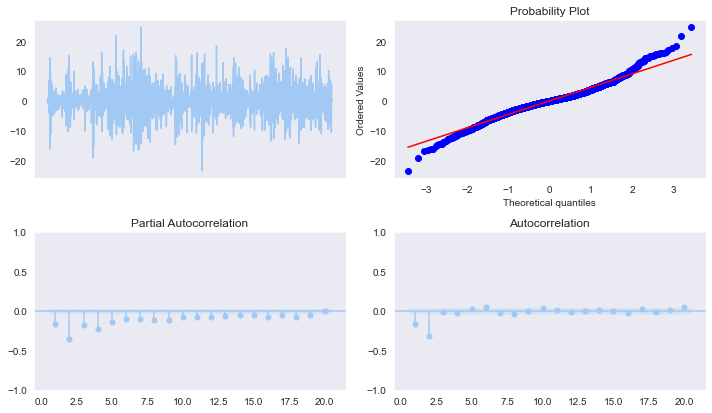

In [21]:
correlograma(btc_resid, lags = 20)

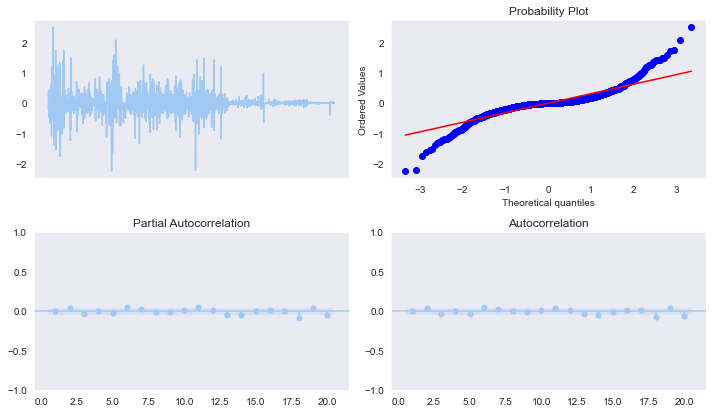

In [22]:
correlograma(tether_resid, lags = 20)

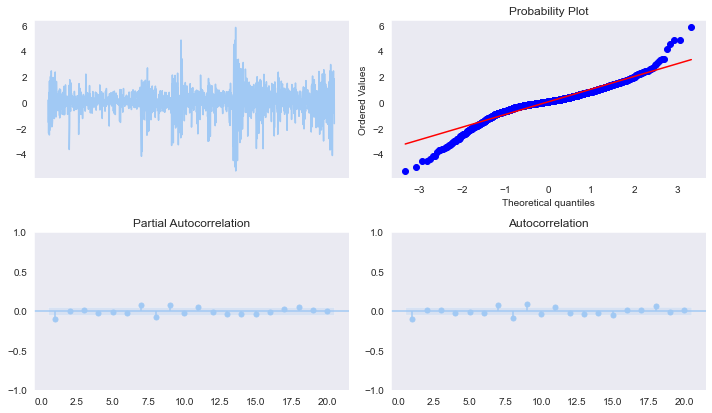

In [23]:
correlograma(sp500_resid, lags = 20)

Según los correlogramas presentados observamos que, de los primeros 40 retrasos de los retornos logarítmicos, la gran mayoría no son significativos tanto en la función de autocorrelación como en la de autocorrelación parcial. Aquellos que lo son pueden ser considerados aleatorios. 

Por el otro lado, en cuanto al QQ plot, podemos ver que los valores se aproximan a la normalidad aunque en las colas se distancien de la línea de referencia, lo que nos da indicios de existencia de heterocedasticidad condicionada.

En conclusión, podemos considerar que los residuos del modelo ARIMA no tienen ningún problema que nos obligue a tener que buscar otro modelo.

#### Análisis de los residuos al cuadrado del modelo ARIMA

Para la evaluación de los residuos al cuadrado del modelo ARIMA haremos lo siguiente:
- Buscaremos la autocorrelación de los errores a través de la función de autocorrelación y de autocorrelación parcial. Al contrario que con los residuos normales, los errores esta vez deben ser en su mayoría significativos.
- Aplicaremos el test Box-Jenkins, que nos informará de la existencia de efecto ARCH en los residuos.

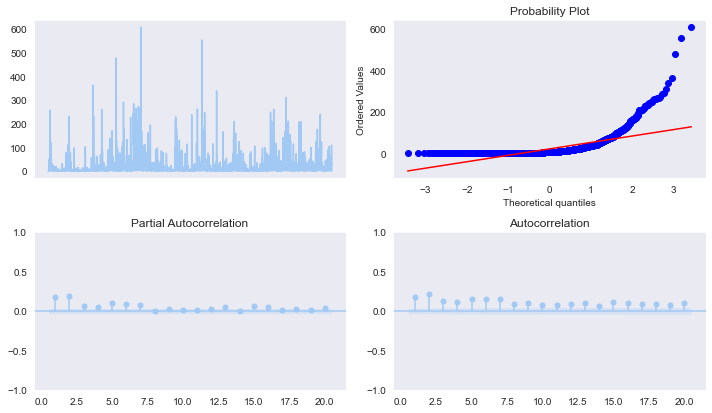

In [24]:
correlograma(btc_resid**2, lags = 20)

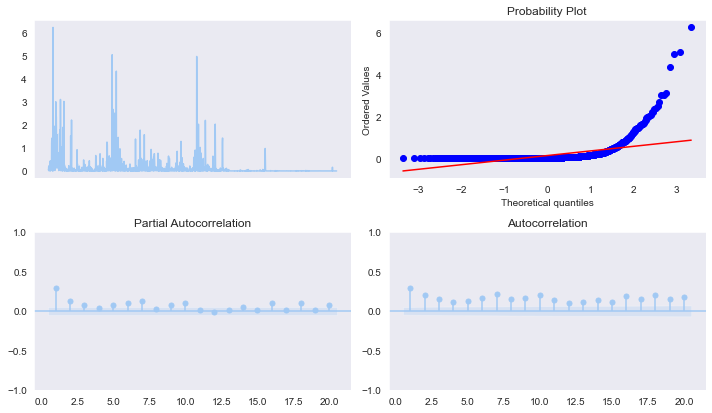

In [25]:
correlograma(tether_resid**2, lags = 20)

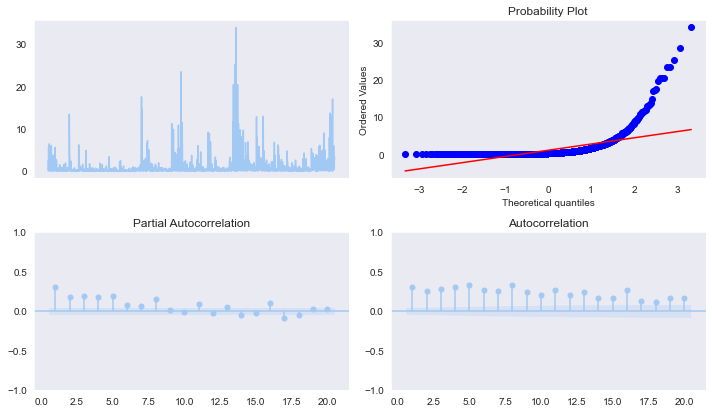

In [26]:
correlograma(sp500_resid**2, lags = 20)

In [27]:
for asset, name in zip([btc_resid**2, tether_resid**2, sp500_resid**2], ['bitcoin','tether','SP500']):
    print('Test de Box-Ljung para {}'.center(125, '-').format(str(name)))
    print(sm.stats.acorr_ljungbox(asset, lags=[40], return_df=True))

--------------------------------------------------Test de Box-Ljung para bitcoin--------------------------------------------------
       lb_stat      lb_pvalue
40  795.388719  4.083966e-141
--------------------------------------------------Test de Box-Ljung para tether--------------------------------------------------
        lb_stat      lb_pvalue
40  1363.178125  5.671864e-260
--------------------------------------------------Test de Box-Ljung para SP500--------------------------------------------------
        lb_stat  lb_pvalue
40  2140.498422        0.0


La función de autocorrelación y de autocorrelación parcial demuestra una clara significancia de los retrasos de los residuos logarítmicos al cuadrado de los tres instrumentos de inversión. 

Además, se rechaza por tres veces la hipótesis nula del Test de Box-Ljung, verificando la correlación entre sí de los errores al cuadrado.

### 2.3. Modelización GARCH (3/4)

En este apartado se estiman 6 tipos de modelos GARCH: GARCH, FIGARCH, EGARCH, GJR-GARCH y TARCH. A través de una función, se presenta una tabla donde se recogen los valores de los parámetros de cada modelo junto a su significancia en paréntesis junto a los criterios de información AIC, BIC y loglikelihood. 

El criterio de selección del mejor modelo será el que minimice los dos primeros criterios de información mencionados.

In [28]:
def garch_table(arima_residuals):
    garch_table = pd.DataFrame()
    for model in ['GARCH', 'FIGARCH', 'EGARCH', 'HARCH', 'GJR-GARCH', 'TARCH']:
        if model in ['GARCH','FIGARCH','EGARCH','HARCH']:
            basic_garch = arch_model(arima_residuals, p = 1, q = 1, mean = 'Zero', vol = model, dist = 't')
        if model == 'GJR-GARCH':
            basic_garch = arch_model(arima_residuals, p = 1, q = 1, o = 1, mean = 'Zero', dist = 't')
        if model == 'TARCH':
            basic_garch = arch_model(arima_residuals, p = 1, q = 1, o = 1, power = 1.0, mean = 'Zero', dist = 't')          
        gm_result = basic_garch.fit(update_freq = 4, disp = 0)
        def p_value_criteria(x):
            if x < 0.001:
                return ' (***)'
            elif x < 0.01:
                return ' (**)'
            elif x < 0.05:
                return ' (*)'
        p_values = gm_result.pvalues.apply(p_value_criteria)
        params_series = round(gm_result.params, 3).astype(str) + p_values
        garch_table[model] = pd.concat([params_series, pd.Series({'AIC': round(gm_result.aic,4)}), pd.Series({'BIC': round(gm_result.bic,4)}),
                                       pd.Series({'loglikelihood': round(gm_result.loglikelihood,4)})])
    garch_table = garch_table.fillna('-')
    return garch_table

In [29]:
garch_table(btc_resid)

,GARCH,FIGARCH,EGARCH,HARCH,GJR-GARCH,TARCH
omega,-,-,0.126 (***),14.643 (***),-,0.205 (**)
alpha[1],0.176 (***),-,0.382 (***),0.582 (***),0.137 (***),0.158 (***)
beta[1],0.824 (***),-,0.965 (***),-,0.821 (***),0.81 (***)
nu,5.13 (***),-,4.669 (***),3.62 (***),5.161 (***),5.209 (***)
AIC,13117.9163,13118.5089,13108.8025,13421.2842,13115.2384,13123.0849
BIC,13140.9598,13147.3134,13131.846,13438.5669,13144.0429,13151.8894
loglikelihood,-6554.9581,-6554.2545,-6550.4012,-6707.6421,-6552.6192,-6556.5425


In [30]:
garch_table(tether_resid)

,GARCH,FIGARCH,EGARCH,HARCH,GJR-GARCH,TARCH
omega,0.002 (***),0.0 (***),-,0.017 (***),0.002 (***),-
alpha[1],0.2 (***),-,0.215 (***),1.0 (***),0.2 (***),0.13 (**)
beta[1],0.78 (***),-,0.994 (***),-,0.68 (***),0.87 (***)
nu,4.752 (***),3.897 (***),3.263 (***),2.947 (***),4.683 (***),5.002 (***)
AIC,-729.4509,-1266.4741,-1307.4268,-320.9119,-825.6515,-1245.6965
BIC,-707.7734,-1239.3772,-1285.7493,-304.6538,-798.5546,-1218.5996
loglikelihood,368.7255,638.237,657.7134,163.456,417.8258,627.8482


In [31]:
garch_table(sp500_resid)

,GARCH,FIGARCH,EGARCH,HARCH,GJR-GARCH,TARCH
omega,0.019 (**),0.024 (*),-,0.758 (***),0.025 (***),0.037 (***)
alpha[1],0.186 (***),-,0.351 (***),0.71 (***),-,-
beta[1],0.814 (***),-,0.972 (***),-,0.818 (***),0.863 (***)
nu,5.28 (***),5.556 (***),4.952 (***),2.964 (***),5.561 (***),6.04 (***)
AIC,3878.6418,3872.884,3895.479,4178.4542,3827.6574,3811.4171
BIC,3900.1951,3899.8256,3917.0323,4194.6192,3854.599,3838.3587
loglikelihood,-1935.3209,-1931.442,-1943.7395,-2086.2271,-1908.8287,-1900.7085


Como podemos observar, el mejor modelo estimador tanto de bitcoin como de tether es el modelo E-GARCH. Por otro lado, el modelo TARCH/ZARCH consigue el mejor resultado para el SP500.

### 2.4. Estudio de los residuos GARCH estimados (4/4)

En este apartado, verificaremos si los modelos GARCH escogidos consiguen eliminar la heterocedasticidad del modelo. Lo haremos estudiando la no autocorrelación entre los errores estandarizados al cuadrado de estos con el test de box-ljung para 40 niveles de retardo.

In [32]:
def ljung_box(garch_result, asset):
    # creando residuos estandarizados
    residuals = garch_result.resid
    volatility = garch_result.conditional_volatility
    squared_standardized_residuals = (residuals/volatility)**2
    # test ljung-box
    for i in range(1,40):
        p_value = float(sm.stats.acorr_ljungbox(squared_standardized_residuals, lags=[i], return_df=True)['lb_pvalue'])
        plt.scatter(i, p_value, marker = 'X')
    plt.axhline(0.05)
    plt.axhline(0.1)
    plt.xlabel('Retardos')
    plt.ylabel('P-valor')
    plt.ylim(0,1)
    plt.show()
        

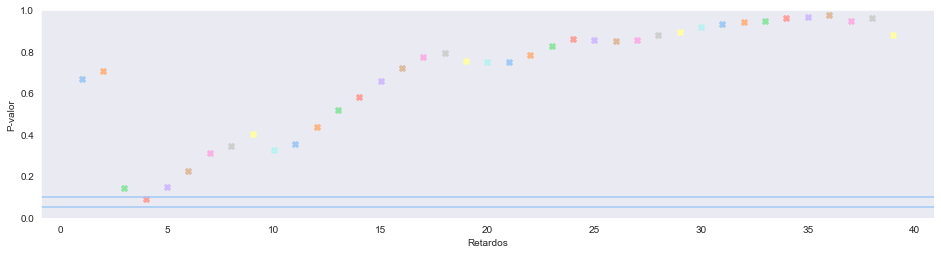

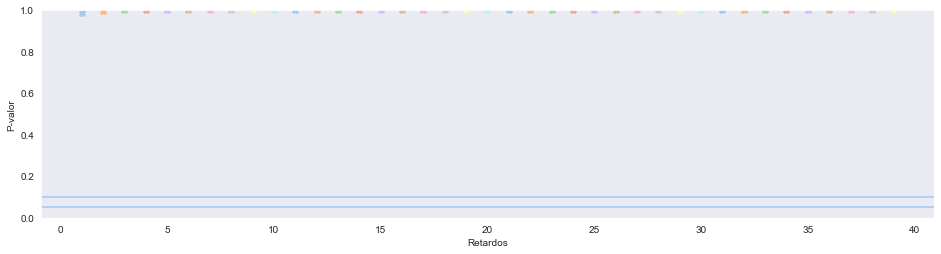

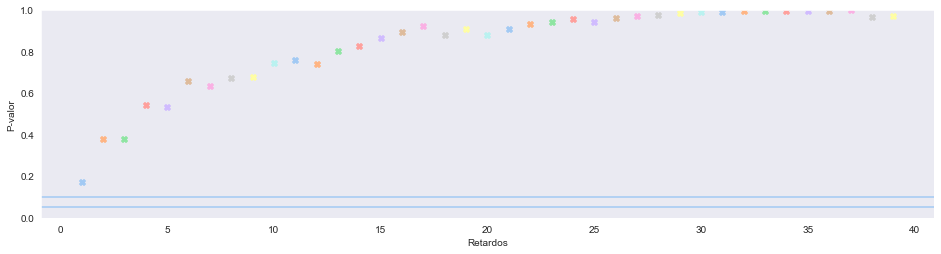

In [33]:
plt.rcParams["figure.figsize"] = (16,13)
plt.subplot(311)
btc_garch = arch_model(btc_resid, p = 1, q = 1, mean = 'Zero', vol = 'EGARCH', dist = 't')
btc_garch_result = btc_garch.fit(update_freq = 4, disp = 0)
ljung_box(btc_garch_result, 'bitcoin')
plt.subplot(312)
tether_garch = arch_model(tether_resid, p = 1, q = 1, mean = 'Zero', vol = 'EGARCH', dist = 't')
tether_garch_result = tether_garch.fit(update_freq = 4, disp = 0)
ljung_box(tether_garch_result, 'tether')
plt.subplot(313)
sp500_garch = arch_model(sp500_resid, p = 1, q = 1, o = 1, mean = 'Zero', dist = 't') 
sp500_garch_result = sp500_garch.fit(update_freq = 4, disp = 0)
ljung_box(sp500_garch_result, 'SP500')
plt.show()

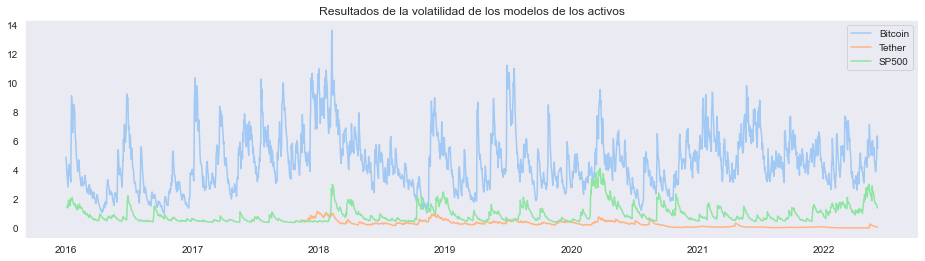

In [48]:
plt.figure(figsize = (16,4))
plt.title('Resultados de la volatilidad de los modelos de los activos')
plt.plot(btc_garch_result.conditional_volatility, label = 'Bitcoin')
plt.plot(tether_garch_result.conditional_volatility, label = 'Tether')
plt.plot(sp500_garch_result.conditional_volatility, label = 'SP500')
plt.legend(loc = 'upper right')
plt.show()


In [35]:
btc_vol = btc_garch_result.conditional_volatility
tether_vol = tether_garch_result.conditional_volatility
sp500_vol = sp500_garch_result.conditional_volatility

In [36]:
btc_std_vol = (btc_vol - btc_vol.min())/(btc_vol.max() - btc_vol.min())
tether_std_vol = (tether_vol - tether_vol.min())/(tether_vol.max() - tether_vol.min())
sp500_std_vol = (sp500_vol - sp500_vol.min())/(sp500_vol.max() - sp500_vol.min())

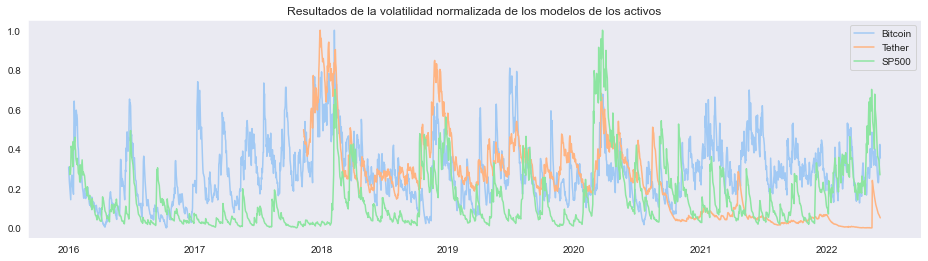

In [49]:
plt.figure(figsize = (16,4))
plt.title('Resultados de la volatilidad normalizada de los modelos de los activos')
plt.plot(btc_std_vol, label = 'Bitcoin')
plt.plot(tether_std_vol, label = 'Tether')
plt.plot(sp500_std_vol, label = 'SP500')
plt.legend()
plt.show()